In [1]:
import pandas as pd
### 시각화를 위한 라이브러리
# - 파이썬 시각화에서 가장 기본적인 시각화 라이브러리
import matplotlib.pyplot as plt

### 한글처리
from matplotlib import font_manager, rc

### 운영체제 확인 라이브러리
import platform

### 시각화 시 마이너스(-, 음수) 기호 깨짐 방지
plt.rcParams["axes.unicode_minus"] = False

### OS별 한글처리
# - 윈도우 운영체게
if platform.system() == "Windows" :
    # path = "c:/Windows/Fonts/malgun.ttf"
    # font_name = font_manager.FontProperties(fname=path).get_name()
    # rc("font", family = font_name)
    
    ### 또는 아래처럼 한줄로도 가능 (아래 한글처리를 주로 사용합니다.)
    plt.rc("font", family = "Malgun Gothic")

# - Mac 운영체제
elif platform.system() == "Darwin" :
    rc("font", family = "AppleGothic")
    
else :
    print("넌 누구?")

In [2]:
cn7 = pd.read_csv("./data/labeled_data.csv")
cn7 = cn7.drop(columns=["_id", "TimeStamp","PART_FACT_PLAN_DATE", "PART_FACT_SERIAL",
                        "EQUIP_NAME", "EQUIP_CD", "Reason", "Clamp_Open_Position",
                        "Mold_Temperature_1","Mold_Temperature_2","Mold_Temperature_5","Mold_Temperature_6",
                        "Mold_Temperature_7","Mold_Temperature_8","Mold_Temperature_9","Mold_Temperature_10",
                        "Mold_Temperature_11","Mold_Temperature_12","Barrel_Temperature_7","Switch_Over_Position"])
cn7 = cn7[(cn7["PART_NAME"] =="CN7 W/S SIDE MLD'G RH") | (cn7["PART_NAME"] =="CN7 W/S SIDE MLD'G LH")]
cn7 = cn7.drop(columns=["PART_NAME"])
cn7 = cn7.replace("Y", 1).replace("N", 0)

C:\Users\Admin\AppData\Local\Temp\ipykernel_14988\3887624601.py:9: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cn7 = cn7.replace("Y", 1).replace("N", 0)


In [3]:
def remove_outliers(df, column):
    # 1사분위수(Q1)와 3사분위수(Q3) 계산
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    
    # IQR 계산
    IQR = Q3 - Q1
    
    # 이상치 범위 설정
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # 이상치 제거
    filtered_df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    
    return filtered_df

In [4]:
cn7_pass = cn7[cn7["PassOrFail"] == 1]
cn7_fail = cn7[cn7["PassOrFail"] == 0]
cn7_pass_removed = cn7_pass.copy()
cn7_pass_removed = remove_outliers(cn7_pass_removed, 'Injection_Time')
cn7_pass_removed = remove_outliers(cn7_pass_removed, 'Plasticizing_Time')
cn7_pass_removed = remove_outliers(cn7_pass_removed, 'Cycle_Time')
cn7_pass_removed = remove_outliers(cn7_pass_removed, 'Max_Injection_Speed')
cn7_pass_removed = remove_outliers(cn7_pass_removed, 'Mold_Temperature_3')
cn7_removed = pd.concat([cn7_pass_removed, cn7_fail], ignore_index=True)


In [5]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_score, accuracy_score, recall_score, f1_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, HistGradientBoostingClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier

grid_df = pd.DataFrame()

# 독립변수 종속변수 분리 
y = cn7_removed["PassOrFail"]
X = cn7_removed.drop(columns=["PassOrFail"])

# 테스트 데이터 분리

# 테스트 데이터 분리
X_train, X_test, y_train, y_test  = train_test_split(X, y, test_size=0.3, random_state=42)

# X_train, y_train 합치기
Xy_train = X_train.copy()
Xy_train["PassOrFail"] = y_train

# Average_Screw_RPM 기준으로 up만 추출하기
Xy_train = Xy_train[Xy_train["Average_Screw_RPM"]>250]

# X_train, y_train 분리
X_train = Xy_train.drop(columns=["PassOrFail"])
y_train = Xy_train["PassOrFail"]

# 데이터 증강
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# 검증 데이터 분리
X_train, X_val, y_train, y_val  = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42)

# 데이터 정규화
ss=StandardScaler()
ss.fit(X_train)
X_train_scaled = ss.transform(X_train)
X_val_scaled = ss.transform(X_val)
X_test_scaled=ss.transform(X_test)

# 모델 생성
rf = RandomForestClassifier(random_state=42)
et = ExtraTreesClassifier(random_state=42)
gb = GradientBoostingClassifier(random_state=42)
hgb = HistGradientBoostingClassifier(random_state=42)
xgb = XGBClassifier(random_state=42)
model_list = [rf, et, gb, hgb, xgb]

# GridSearchCV 이용해서 모든 모델 하이퍼파라미터 튜닝
for model in model_list:
    model_name = model.__class__.__name__
    gridParams = dict()
    if model_name =="XGBClassifier" :
        gridParams["n_estimators"] = [20,50]
        gridParams["max_depth"] = [10,20]
        gridParams["min_child_weight"] = [1, 2,4]
    elif model_name == "HistGradientBoostingClassifier" :
        gridParams["max_iter"] = [20, 50]
        gridParams["max_depth"] = [10, 50]
        gridParams["min_samples_leaf"] = [1,2,4]
    else :
        gridParams["n_estimators"] = [20, 50]
        gridParams["max_depth"] = [10,20]
        gridParams["min_samples_split"] = [2,5,10]
        gridParams["min_samples_leaf"] = [1,2,4]

    grid_search_model = GridSearchCV(model, gridParams, scoring='f1', cv=5, n_jobs=-1)
    grid_search_model.fit(X_train_scaled, y_train)
    model = grid_search_model.best_estimator_
    train_pred = model.predict(X_train_scaled)
    val_pred = model.predict(X_val_scaled)
    
    train_acc = accuracy_score(y_train, train_pred)
    val_acc = accuracy_score(y_val, val_pred)
    
    pre = precision_score(y_val, val_pred)
    rec = recall_score(y_val, val_pred)
    f1 = f1_score(y_val, val_pred)
    
    pred = model.predict(X_test_scaled)
    cm = confusion_matrix(y_test, pred)
    TN = cm[0, 0]  # True Negative
    FP = cm[0, 1]  # False Positive
    FN = cm[1, 0]  # False Negative
    TP = cm[1, 1]  # True Positive
    
    df_temp = pd.DataFrame([[model_name,  train_acc, val_acc, pre, rec, f1, train_acc-val_acc, TN, FP, FN, TP, str(grid_search_model.best_params_)]],
                             columns=["모델명", "훈련_정확도", "검증_정확도", "정밀도", "재현율", "f1-score", "훈련-검증", "TN", "FP", "FN", "TP", "파라미터"])

    grid_df = pd.concat([grid_df, df_temp], ignore_index=True)

In [6]:
grid_df

,모델명,훈련_정확도,검증_정확도,정밀도,재현율,f1-score,훈련-검증,TN,FP,FN,TP,파라미터
0,RandomForestClassifier,0.999119,0.997947,0.996109,1.000000,0.998051,0.001172,10,4,4,1954,"{'max_depth': 20, 'min_samples_leaf': 2, 'min_..."
1,ExtraTreesClassifier,0.998678,0.998973,1.000000,0.998047,0.999022,-0.000295,10,4,4,1954,"{'max_depth': 20, 'min_samples_leaf': 1, 'min_..."
2,GradientBoostingClassifier,0.999119,0.988706,0.994083,0.984375,0.989205,0.010413,11,3,4,1954,"{'max_depth': 20, 'min_samples_leaf': 1, 'min_..."
3,HistGradientBoostingClassifier,0.999559,0.991786,0.996063,0.988281,0.992157,0.007773,10,4,7,1951,"{'max_depth': 50, 'max_iter': 50, 'min_samples..."
4,XGBClassifier,0.999119,0.996920,0.998043,0.996094,0.997067,0.002199,10,4,17,1941,"{'max_depth': 10, 'min_child_weight': 2, 'n_es..."


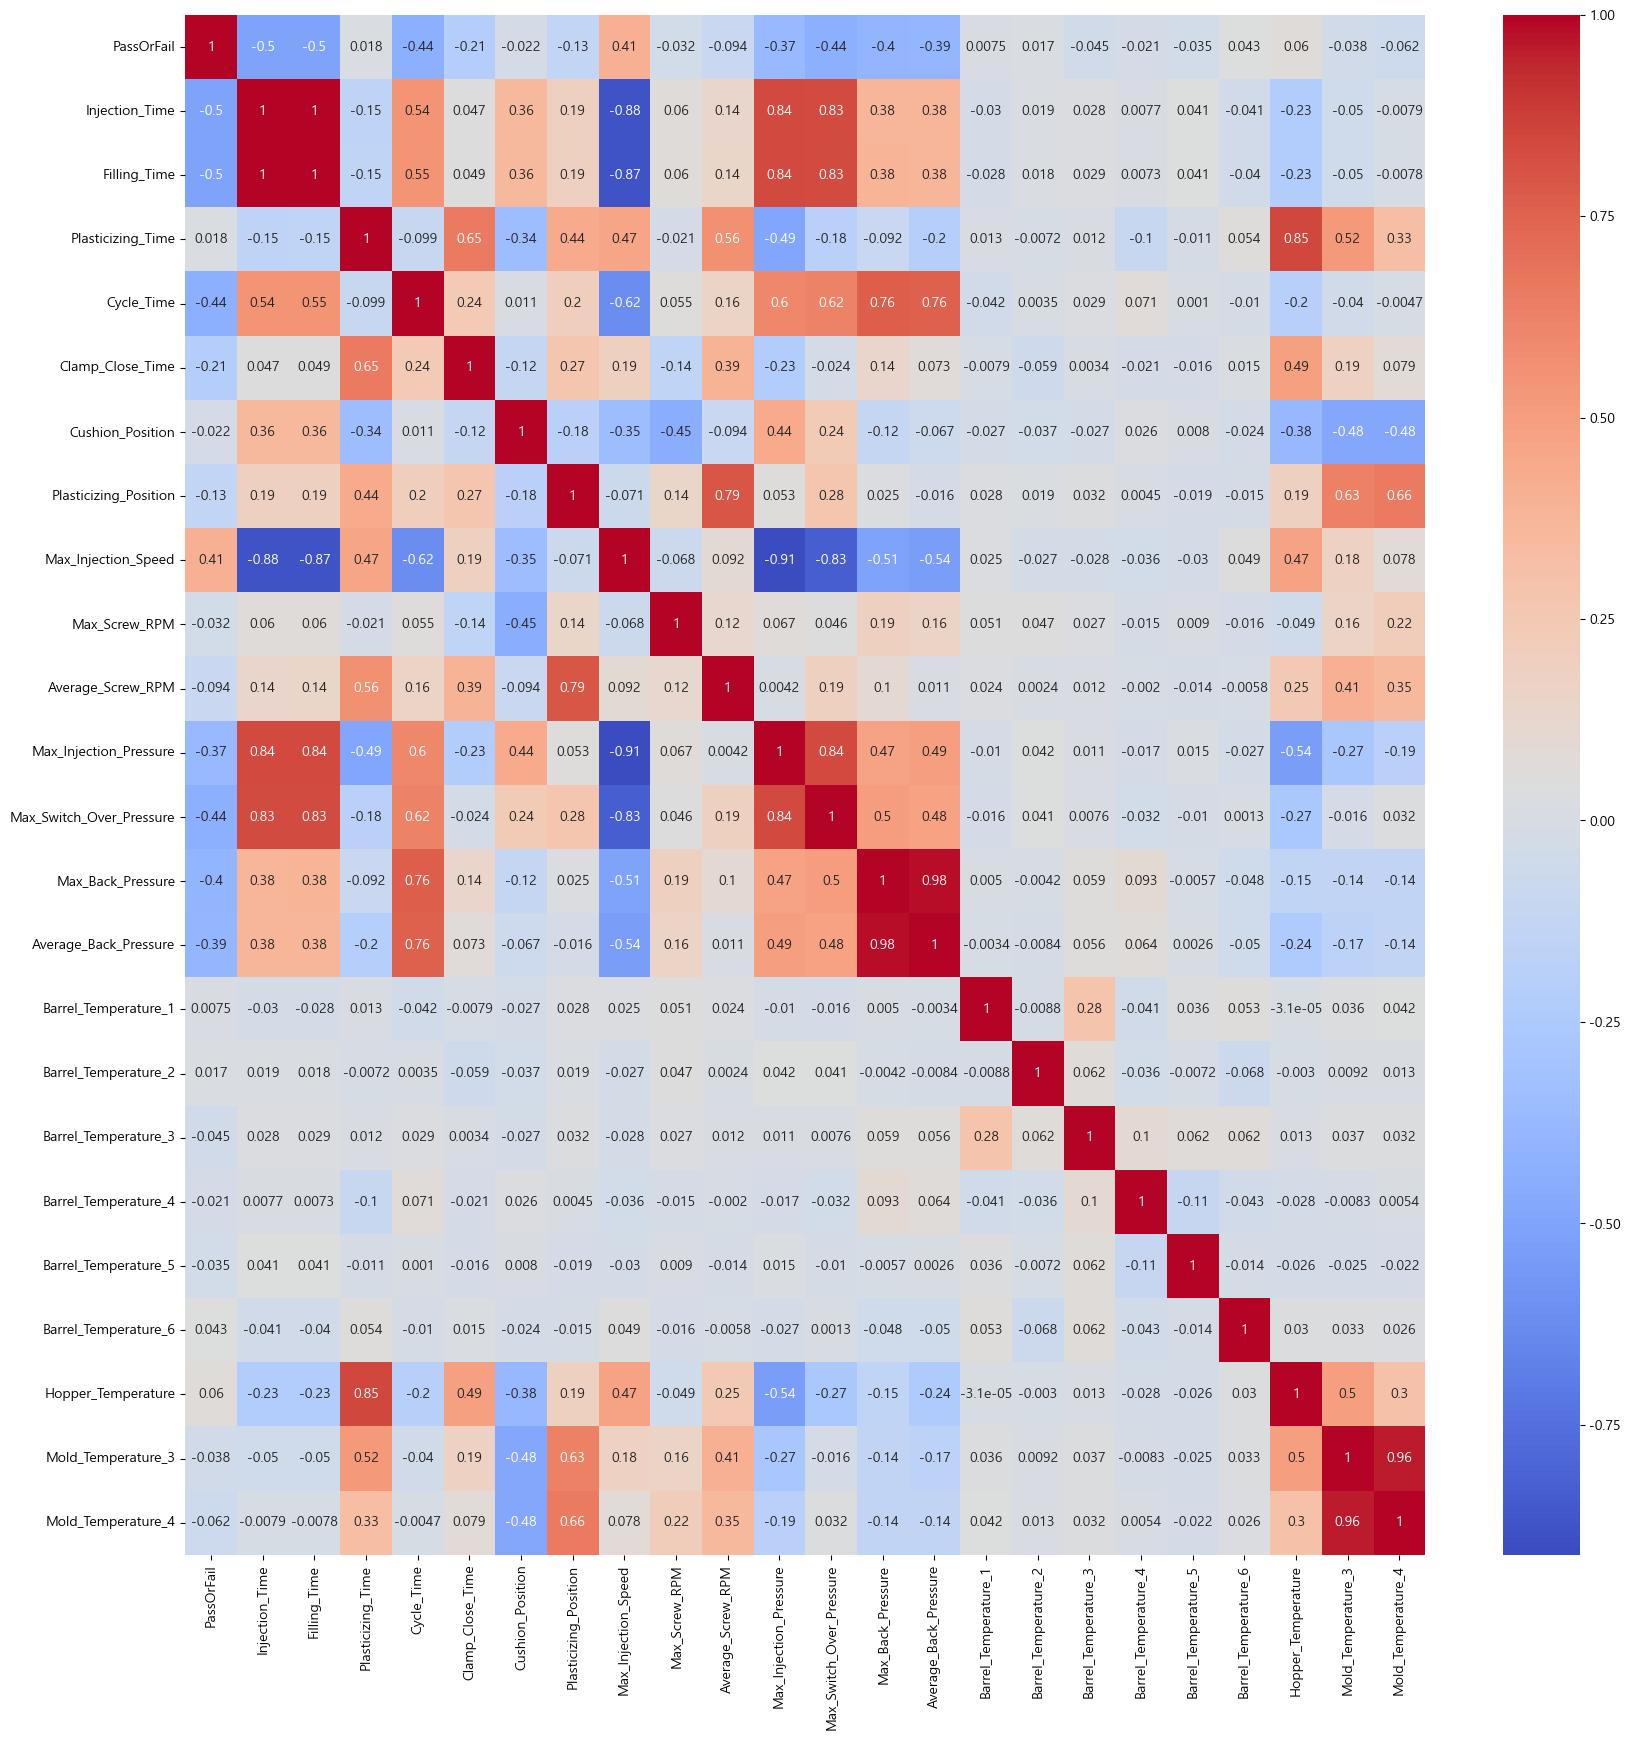

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(20, 20))
sns.heatmap(cn7_removed.corr(), annot=True, cmap='coolwarm')
plt.show()

In [8]:
cn7_removed = cn7_removed.drop(columns=["Filling_Time", "Average_Back_Pressure", "Mold_Temperature_3", "Max_Injection_Pressure", "Plasticizing_Time", "Max_Injection_Speed"])

In [ ]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_score, accuracy_score, recall_score, f1_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, HistGradientBoostingClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier

grid_df = pd.DataFrame()

# 독립변수 종속변수 분리 
y = cn7_removed["PassOrFail"]
X = cn7_removed.drop(columns=["PassOrFail"])

# 테스트 데이터 분리

# 테스트 데이터 분리
X_train, X_test, y_train, y_test  = train_test_split(X, y, test_size=0.3, random_state=42)

# X_train, y_train 합치기
Xy_train = X_train.copy()
Xy_train["PassOrFail"] = y_train

# Average_Screw_RPM 기준으로 up만 추출하기
Xy_train = Xy_train[Xy_train["Average_Screw_RPM"]>250]

# X_train, y_train 분리
X_train = Xy_train.drop(columns=["PassOrFail"])
y_train = Xy_train["PassOrFail"]

# 데이터 증강
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# 검증 데이터 분리
X_train, X_val, y_train, y_val  = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42)

# 데이터 정규화
ss=StandardScaler()
ss.fit(X_train)
X_train_scaled = ss.transform(X_train)
X_val_scaled = ss.transform(X_val)
X_test_scaled=ss.transform(X_test)

# 모델 생성
rf = RandomForestClassifier(random_state=42)
et = ExtraTreesClassifier(random_state=42)
gb = GradientBoostingClassifier(random_state=42)
hgb = HistGradientBoostingClassifier(random_state=42)
xgb = XGBClassifier(random_state=42)
model_list = [rf, et, gb, hgb, xgb]

# GridSearchCV 이용해서 모든 모델 하이퍼파라미터 튜닝
for model in model_list:
    model_name = model.__class__.__name__
    gridParams = dict()
    if model_name =="XGBClassifier" :
        gridParams["n_estimators"] = [20,50]
        gridParams["max_depth"] = [10,20]
        gridParams["min_child_weight"] = [1, 2,4]
    elif model_name == "HistGradientBoostingClassifier" :
        gridParams["max_iter"] = [20, 50]
        gridParams["max_depth"] = [10, 50]
        gridParams["min_samples_leaf"] = [1,2,4]
    else :
        gridParams["n_estimators"] = [20, 50]
        gridParams["max_depth"] = [10,20]
        gridParams["min_samples_split"] = [2,5,10]
        gridParams["min_samples_leaf"] = [1,2,4]

    grid_search_model = GridSearchCV(model, gridParams, scoring='f1', cv=5, n_jobs=-1)
    grid_search_model.fit(X_train_scaled, y_train)
    model = grid_search_model.best_estimator_
    train_pred = model.predict(X_train_scaled)
    val_pred = model.predict(X_val_scaled)
    
    train_acc = accuracy_score(y_train, train_pred)
    val_acc = accuracy_score(y_val, val_pred)
    
    pre = precision_score(y_val, val_pred)
    rec = recall_score(y_val, val_pred)
    f1 = f1_score(y_val, val_pred)
    
    pred = model.predict(X_test_scaled)
    cm = confusion_matrix(y_test, pred)
    TN = cm[0, 0]  # True Negative
    FP = cm[0, 1]  # False Positive
    FN = cm[1, 0]  # False Negative
    TP = cm[1, 1]  # True Positive
    
    df_temp = pd.DataFrame([[model_name,  train_acc, val_acc, pre, rec, f1, train_acc-val_acc, TN, FP, FN, TP, str(grid_search_model.best_params_)]],
                             columns=["모델명", "훈련_정확도", "검증_정확도", "정밀도", "재현율", "f1-score", "훈련-검증", "TN", "FP", "FN", "TP", "파라미터"])

    grid_df = pd.concat([grid_df, df_temp], ignore_index=True)

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(20, 20))
sns.heatmap(cn7_removed.corr(), annot=True, cmap='coolwarm')
plt.show()

In [ ]:
from scipy.stats import spearmanr, pearsonr
y = cn7_removed["PassOrFail"]
X = cn7_removed.drop(columns=["PassOrFail"])
for col_name in X.columns:
    print(col_name)
    print("피어슨")
    print(pearsonr(X[col_name], y))
    print("스피어만")
    print(spearmanr(X[col_name], y))
    print("==================================================================")

In [ ]:
cn7_removed = cn7_removed.drop(columns=["Max_Screw_RPM", "Barrel_Temperature_1", "Barrel_Temperature_2", "Barrel_Temperature_3",
                                         "Barrel_Temperature_4", "Barrel_Temperature_5", "Barrel_Temperature_6"])

In [ ]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_score, accuracy_score, recall_score, f1_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, HistGradientBoostingClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier

# 독립변수 종속변수 분리 
y = cn7_removed["PassOrFail"]
X = cn7_removed.drop(columns=["PassOrFail"])

# 테스트 데이터 분리

# 테스트 데이터 분리
X_train, X_test, y_train, y_test  = train_test_split(X, y, test_size=0.3, random_state=42)

# X_train, y_train 합치기
Xy_train = X_train.copy()
Xy_train["PassOrFail"] = y_train

# Average_Screw_RPM 기준으로 up만 추출하기
Xy_train = Xy_train[Xy_train["Average_Screw_RPM"]>250]

# X_train, y_train 분리
X_train = Xy_train.drop(columns=["PassOrFail"])
y_train = Xy_train["PassOrFail"]

# 데이터 증강
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# 검증 데이터 분리
X_train, X_val, y_train, y_val  = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42)

# 데이터 정규화
ss=StandardScaler()
ss.fit(X_train)
X_train_scaled = ss.transform(X_train)
X_val_scaled = ss.transform(X_val)
X_test_scaled=ss.transform(X_test)

# 모델 생성
rf = RandomForestClassifier(random_state=42)
et = ExtraTreesClassifier(random_state=42)
gb = GradientBoostingClassifier(random_state=42)
hgb = HistGradientBoostingClassifier(random_state=42)
xgb = XGBClassifier(random_state=42)
model_list = [rf, et, gb, hgb, xgb]

# GridSearchCV 이용해서 모든 모델 하이퍼파라미터 튜닝
for model in model_list:
    model_name = model.__class__.__name__
    gridParams = dict()
    if model_name =="XGBClassifier" :
        gridParams["n_estimators"] = [20,50]
        gridParams["max_depth"] = [10,20]
        gridParams["min_child_weight"] = [1, 2,4]
    elif model_name == "HistGradientBoostingClassifier" :
        gridParams["max_iter"] = [20, 50]
        gridParams["max_depth"] = [10, 50]
        gridParams["min_samples_leaf"] = [1,2,4]
    else :
        gridParams["n_estimators"] = [20, 50]
        gridParams["max_depth"] = [10,20]
        gridParams["min_samples_split"] = [2,5,10]
        gridParams["min_samples_leaf"] = [1,2,4]

    grid_search_model = GridSearchCV(model, gridParams, scoring='f1', cv=5, n_jobs=-1)
    grid_search_model.fit(X_train_scaled, y_train)
    model = grid_search_model.best_estimator_
    train_pred = model.predict(X_train_scaled)
    val_pred = model.predict(X_val_scaled)
    
    train_acc = accuracy_score(y_train, train_pred)
    val_acc = accuracy_score(y_val, val_pred)
    
    pre = precision_score(y_val, val_pred)
    rec = recall_score(y_val, val_pred)
    f1 = f1_score(y_val, val_pred)
    
    pred = model.predict(X_test_scaled)
    cm = confusion_matrix(y_test, pred)
    TN = cm[0, 0]  # True Negative
    FP = cm[0, 1]  # False Positive
    FN = cm[1, 0]  # False Negative
    TP = cm[1, 1]  # True Positive
    
    df_temp = pd.DataFrame([[model_name,  train_acc, val_acc, pre, rec, f1, train_acc-val_acc, TN, FP, FN, TP, str(grid_search_model.best_params_)]],
                             columns=["모델명", "훈련_정확도", "검증_정확도", "정밀도", "재현율", "f1-score", "훈련-검증", "TN", "FP", "FN", "TP", "파라미터"])

    grid_df = pd.concat([grid_df, df_temp], ignore_index=True)

In [ ]:
grid_df

In [ ]:
grid_df["파라미터"][7]

In [ ]:
model = GradientBoostingClassifier(max_depth=20, min_samples_leaf=1, min_samples_split=10, n_estimators=20)

In [ ]:
model.fit(X_train_scaled, y_train)

In [ ]:
import shap
explainer = shap.Explainer(model, X_train_scaled)
shap_values = explainer(X_train_scaled,  check_additivity=False)

# X_train_scaled를 DataFrame으로 변환
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns)

# SHAP 요약 플롯 생성
shap.summary_plot(shap_values, X_train_scaled_df)

In [ ]:
list(y_train)[1]

In [ ]:
tmp = X_train_scaled[0].copy()

In [ ]:
tmp[5] = -0.5

In [ ]:
import shap
import pandas as pd

# 정규화된 데이터를 DataFrame으로 변환 (원래 독립변수 명 사용)
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns)

# SHAP Explainer 생성 및 SHAP 값 계산 (additivity 검증 비활성화)
explainer = shap.Explainer(model, X_train_scaled_df)
shap_values = explainer(X_train_scaled_df, check_additivity=False)

# 하나의 샘플 선택 (예: 인덱스 0)
sample_idx = 1

# 선택한 샘플에 대한 SHAP 값을 waterfall 플롯으로 시각화
shap.plots.waterfall(shap_values[sample_idx])


In [ ]:
X_train_scaled_df.iloc[1]

In [ ]:
X_train_scaled_df.at[1, "Injection_Time"] = 0.5

In [ ]:
import shap
import pandas as pd

# SHAP Explainer 생성 및 SHAP 값 계산 (additivity 검증 비활성화)
explainer = shap.Explainer(model, X_train_scaled_df) 
shap_values = explainer(X_train_scaled_df, check_additivity=False)

# 하나의 샘플 선택 (예: 인덱스 0)
sample_idx = 1

# 선택한 샘플에 대한 SHAP 값을 waterfall 플롯으로 시각화
shap.plots.waterfall(shap_values[sample_idx])


In [ ]:
import numpy as np
import pandas as pd

# SHAP 값은 explainer 호출 후 shap_values 객체에 저장됩니다.
# 각 피처의 평균 절대 기여도를 계산합니다.
mean_abs_shap = np.mean(np.abs(shap_values.values), axis=0)

# DataFrame으로 정리하여 피처명과 함께 보기 좋게 구성합니다.
shap_importance_df = pd.DataFrame({
    'Feature': X_train_scaled_df.columns,
    'Mean_Absolute_SHAP': mean_abs_shap
})

# 평균 절대 SHAP 값 기준 내림차순 정렬
shap_importance_df.sort_values('Mean_Absolute_SHAP', ascending=False, inplace=True)
print(shap_importance_df)

In [ ]:
X_train = X_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)

In [ ]:
X_train

In [ ]:
model = GradientBoostingClassifier(max_depth=20, min_samples_leaf=1, min_samples_split=10, n_estimators=20)

In [ ]:
model.fit(X_train_scaled, y_train)

In [ ]:
y_train

In [ ]:
# 정규화된 데이터를 DataFrame으로 변환 (원래 독립변수 명 사용)
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns)

# SHAP Explainer 생성 및 SHAP 값 계산 (additivity 검증 비활성화)
explainer = shap.Explainer(model, X_train_scaled_df)
shap_values = explainer(X_train_scaled_df, check_additivity=False)

# 하나의 샘플 선택 (예: 인덱스 0)
sample_idx = 2269

# 선택한 샘플에 대한 SHAP 값을 waterfall 플롯으로 시각화
shap.plots.waterfall(shap_values[sample_idx])


In [ ]:
X_train["Clamp_Close_Time"][2269]

In [ ]:
df = X_train.copy()

In [ ]:
df["PassOrFail"] = y_train

In [ ]:
df.at[2269, "PassOrFail"] = 1

In [ ]:
df_Y = df[df["PassOrFail"] == 1]

In [ ]:
df_Y["Clamp_Close_Time"]

In [ ]:
df_Y_droped = df_Y.drop(columns="Clamp_Close_Time")

In [ ]:
df_Y_droped

In [ ]:
from sklearn.neighbors import NearestNeighbors
import numpy as np

nbrs = NearestNeighbors(n_neighbors=10, metric='euclidean').fit(df_Y_droped)

distances, indices = nbrs.kneighbors([df_Y_droped.loc[2269]])

# indices[0]에는 자기 자신과 가장 가까운 11개의 인덱스가 담김
# 첫 번째 인덱스(자기 자신)는 제외하고, 나머지 10개를 선택
neighbors10 = indices[0][1:11]

print("가장 비슷한 10개의 샘플 인덱스:", neighbors10)


In [ ]:
df_Y_droped.reset_index()

In [ ]:
df_Y_droped.reset_index().iloc[1110]

In [ ]:
df_Y_droped.reset_index().iloc[208]

In [ ]:
df.loc[413]

In [ ]:
df.loc[2269]

In [ ]:

from sklearn.tree import export_graphviz
import graphviz

tree = model.estimators_[0, 0]

# 트리 구조를 export하여 DOT 형식으로 저장
export_graphviz(tree,
                out_file="tree.dot",
                feature_names=feature_names,
                class_names=class_names,
                rounded=True,
                filled=True)

# DOT 파일 읽어 Graphviz로 렌더링하기
with open("tree.dot") as f:
    dot_graph = f.read()
graph = graphviz.Source(dot_graph)
graph.render("gradient_boosting_tree")  # 파일로 저장
graph  # 노트북에서 직접 보기